# Synthetic control with `pymc` models

In [1]:
import arviz as az

import causalpy as cp

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## Load data

In [3]:
df = cp.load_data("sc")
treatment_time = 70

## Run the analysis

:::{note}
The `random_seed` keyword argument for the PyMC sampler is not neccessary. We use it here so that the results are reproducible.
:::

In [4]:
# Note, we do not want an intercept in this model
result = cp.pymc_experiments.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


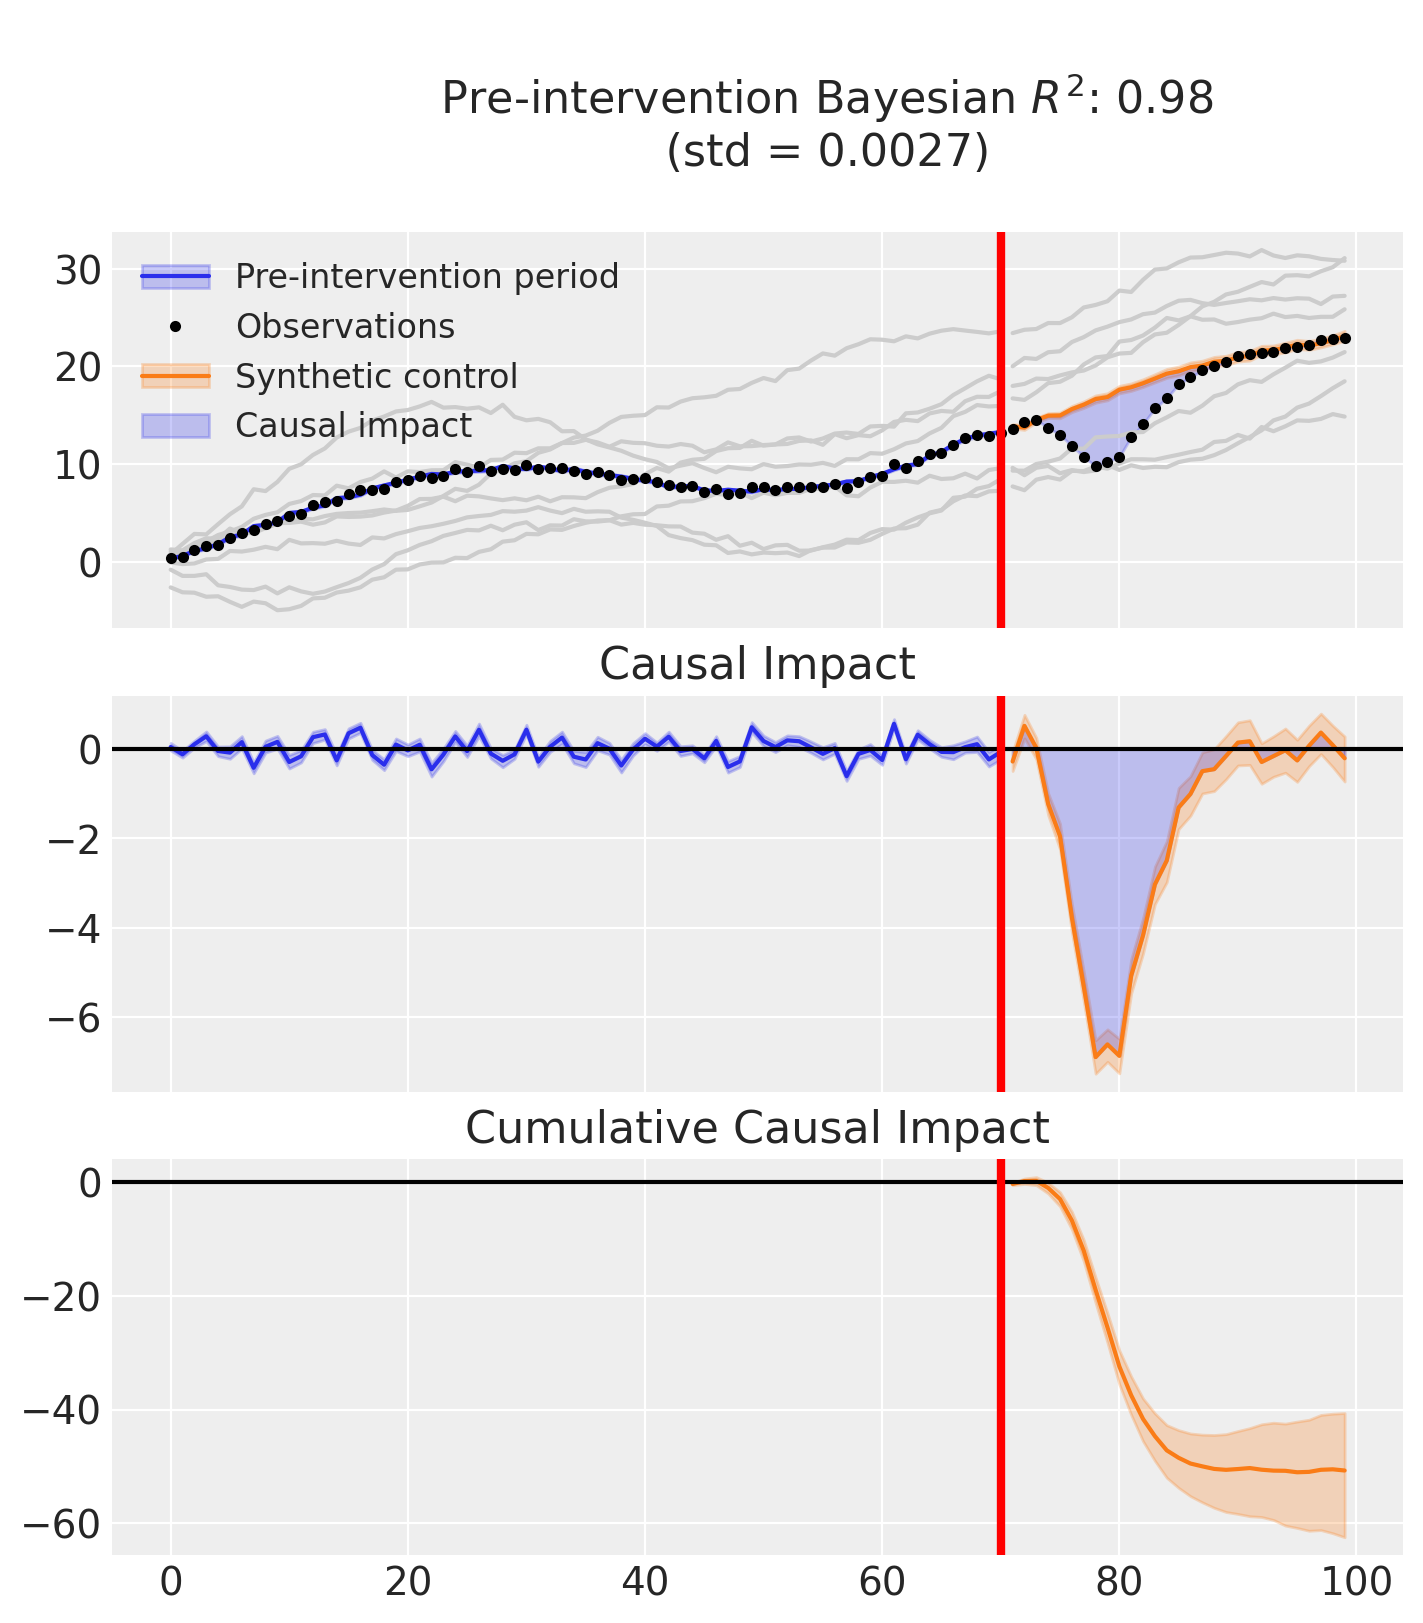

In [5]:
fig, ax = result.plot(plot_predictors=True)

In [6]:
result.summary()

==================================Pre-Post Fit==================================
Formula: actual ~ 0 + a + b + c + d + e + f + g
Model coefficients:
a                             0.34, 94% HDI [0.30, 0.38]
b                             0.05, 94% HDI [0.01, 0.09]
c                             0.31, 94% HDI [0.26, 0.35]
d                             0.06, 94% HDI [0.01, 0.10]
e                             0.02, 94% HDI [0.00, 0.07]
f                             0.19, 94% HDI [0.11, 0.26]
g                             0.04, 94% HDI [0.00, 0.08]
sigma                         0.26, 94% HDI [0.22, 0.30]


As well as the model coefficients, we might be interested in the avarage causal impact and average cumulative causal impact.

<div class="alert alert-info">

Note

Better output for the summary statistics are in progress!

</div>

In [7]:
az.summary(result.post_impact.mean("obs_ind"))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-1.75,0.203,-2.155,-1.401,0.005,0.004,1474.0,1775.0,1.0


:::{Warning}

Care must be taken with the mean impact statistic. It only makes sense to use this statistic if it looks like the intervention had a lasting (and roughly constant) effect on the outcome variable. If the effect is transient, then clearly there will be a lot of post-intervention period where the impact of the intervention has 'worn off'. If so, then it will be hard to interpret the mean impacts real meaning.
:::

We can also ask for the summary statistics of the _cumulative_ causal impact.

In [8]:
# get index of the final time point
index = result.post_impact_cumulative.obs_ind.max()
# grab the posterior distribution of the cumulative impact at this final time point
last_cumulative_estimate = result.post_impact_cumulative.sel({"obs_ind": index})
# get summary stats
az.summary(last_cumulative_estimate)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x,-50.741,5.887,-62.499,-40.621,0.154,0.109,1474.0,1775.0,1.0
